Iteration: 500  Loss: 0.11428724974393845  Accuracy: 96.36 %
Iteration: 1000  Loss: 0.11025173217058182  Accuracy: 97.64 %
Iteration: 1500  Loss: 0.17571310698986053  Accuracy: 97.86 %
Iteration: 2000  Loss: 0.054721102118492126  Accuracy: 98.01 %


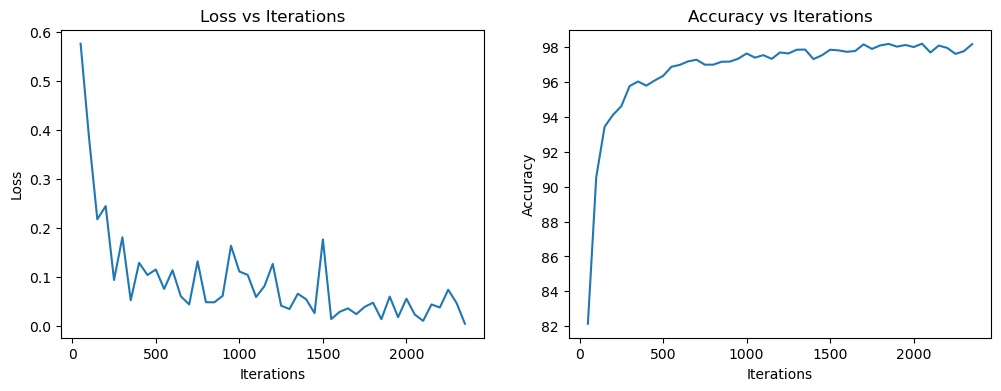

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Load and prepare the dataset
train_data = pd.read_csv(r"../../lesson1/input/train.csv", dtype=np.float32)

# Split data into features (pixels) and labels (numbers from 0 to 9)
targets_numpy = train_data.label.values
features_numpy = (
    train_data.loc[:, train_data.columns != "label"].values / 255
)  # normalization

# Train-test split (80% training, 20% testing)
features_train, features_test, targets_train, targets_test = train_test_split(
    features_numpy, targets_numpy, test_size=0.2, random_state=42
)

# Convert features and targets to PyTorch tensors
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(
    torch.LongTensor
)  # data type is long

featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor)  # data type is long

# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(featuresTrain, targetsTrain)
test_dataset = TensorDataset(featuresTest, targetsTest)

batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.cnn1 = nn.Conv2d(
            in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0
        )
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(
            in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0
        )
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(32 * 4 * 4, 10)

    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)

        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)

        out = out.view(out.size(0), -1)
        out = self.fc1(out)

        return out


# Instantiate the model, define loss function and optimizer
model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Calculate the number of epochs based on iterations
n_iters = 2500
num_epochs = int(n_iters / (len(features_train) / batch_size))

# Train the CNN model
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(-1, 1, 28, 28))
        labels = Variable(labels)

        # Clear gradients
        optimizer.zero_grad()

        # Forward propagation
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backpropagation and update
        loss.backward()
        optimizer.step()

        count += 1

        if count % 50 == 0:
            # Calculate accuracy on the test set
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = Variable(images.view(-1, 1, 28, 28))
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            accuracy = 100 * correct / total

            # Store loss and accuracy for plotting
            loss_list.append(loss.item())
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if count % 500 == 0:
            print(
                f"Iteration: {count}  Loss: {loss.item()}  Accuracy: {accuracy:.2f} %"
            )

# Plotting the results (loss and accuracy)
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(iteration_list, loss_list)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss vs Iterations")

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(iteration_list, accuracy_list)
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Iterations")

plt.show()